In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [61]:
# -------------------------
# Mask prediction head
# -------------------------
class MaskModule(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.class_head = nn.Linear(embed_dim, num_classes)
        self.mask_mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim),
        )

    def forward(self, query_tokens, feature_map):
        class_logits = self.class_head(query_tokens)  # [B, Q, num_classes]
        mask_embeds = self.mask_mlp(query_tokens)    # [B, Q, D]
        masks = torch.einsum("bqd,bnd->bqn", mask_embeds, feature_map)
        return class_logits, masks

In [62]:
# -------------------------
# EoMT model
# -------------------------
class EoMT(nn.Module):
    def __init__(self, vit, num_queries=100, num_classes=80, L1=8, L2=4):
        super().__init__()
        self.vit = vit
        self.embed_dim = vit.embed_dim
        self.num_queries = num_queries

        # Learnable queries
        self.query_tokens = nn.Parameter(torch.randn(num_queries, self.embed_dim))

        # Mask module
        self.mask_module = MaskModule(self.embed_dim, num_classes)

        # Split encoder
        self.encoder_blocks_L1 = vit.blocks[:L1]
        self.encoder_blocks_L2 = vit.blocks[L1:L1+L2]
        self.norm = vit.norm

    def forward(self, x):
        B = x.shape[0]

        # Patch embedding
        x = self.vit.patch_embed(x)  # [B, N, D]
        cls_token = self.vit.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.vit.pos_embed[:, :x.size(1), :]
        x = self.vit.pos_drop(x)

        # Stage 1
        for blk in self.encoder_blocks_L1:
            x = blk(x)

        # Add queries
        queries = self.query_tokens.unsqueeze(0).expand(B, -1, -1)
        x = torch.cat([x, queries], dim=1)

        # Stage 2
        for blk in self.encoder_blocks_L2:
            x = blk(x)

        x = self.norm(x)

        # Split tokens (drop CLS token)
        patch_tokens, query_tokens = x[:, 1:-self.num_queries, :], x[:, -self.num_queries:, :]
        feature_map = patch_tokens  # [B, N, D]

        return self.mask_module(query_tokens, feature_map)

In [63]:
# -------------------------
# Preprocess + Postprocess
# -------------------------
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    orig_w, orig_h = img.size
    img = img.resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0
    img_tensor = torch.tensor(img_np).permute(2, 0, 1).unsqueeze(0)
    return img_tensor, img_np, (orig_h, orig_w)

In [64]:
# -------------------------
# Visualization
# -------------------------
def visualize_masks(image, masks, num_show=3):
    """
    image: numpy array [H, W, 3]
    masks: torch tensor [Q, H, W] already upsampled to match image size
    """
    H, W, _ = image.shape
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, num_show+1, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    # Overlay a few query masks
    for i in range(num_show):
        plt.subplot(1, num_show+1, i+2)

        # For Dinov2
        mask = masks[i]
        mask = (torch.sigmoid(mask) > 0.5).float()
        mask = mask.cpu().numpy()

        # Show base image
        plt.imshow(image)
        # Overlay mask FULL-SIZE
        plt.imshow(mask, cmap="jet", alpha=0.5, extent=[0, W, H, 0])
        plt.title(f"Mask {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


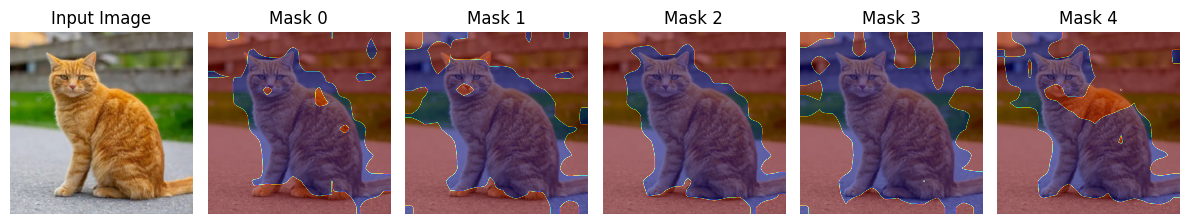

In [123]:
# Load pretrained ViT
vit = create_model("vit_base_patch16_224", pretrained=True)
model = EoMT(vit, num_queries=20, num_classes=80, L1=24, L2=12)
model.eval()

# Load sample image
img_tensor, img_np, (orig_h, orig_w) = preprocess_image("cat.png")

with torch.no_grad():
    class_logits, masks = model(img_tensor)

# Reshape masks -> [B, Q, H_patch, W_patch]
num_queries = masks.shape[1]
H_patch = W_patch = int(masks.shape[-1] ** 0.5)
masks = masks.reshape(1, num_queries, H_patch, W_patch)

# Upsample to original image size
masks = F.interpolate(masks, size=(orig_h, orig_w), mode="bilinear", align_corners=False)
masks = torch.sigmoid(masks[0])  # take batch=0

# Visualize first few
visualize_masks(img_np, masks, num_show=5)

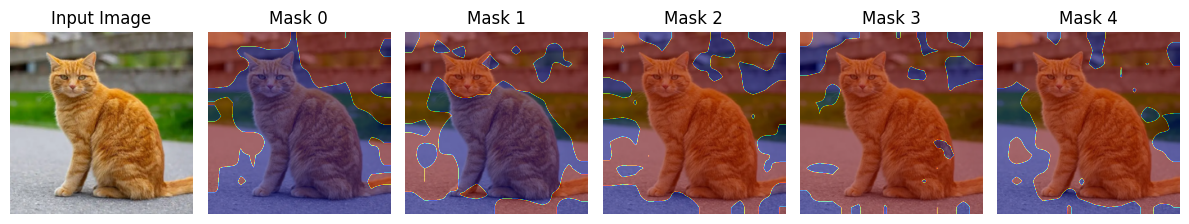

In [134]:
from transformers import AutoModel, AutoModelForPreTraining
model = AutoModel.from_pretrained("facebook/dinov2-base")
# model = AutoModelForPreTraining.from_pretrained("facebook/vit-mae-base")

model = EoMT(vit, num_queries=50, num_classes=80, L1=25, L2=25)
model.eval()

# Load sample image
img_tensor, img_np, (orig_h, orig_w) = preprocess_image("cat.png")

with torch.no_grad():
    class_logits, masks = model(img_tensor)

# Reshape masks -> [B, Q, H_patch, W_patch]
num_queries = masks.shape[1]
H_patch = W_patch = int(masks.shape[-1] ** 0.5)
masks = masks.reshape(1, num_queries, H_patch, W_patch)

# Upsample to original image size
masks = F.interpolate(masks, size=(orig_h, orig_w), mode="bilinear", align_corners=False)
masks = torch.sigmoid(masks[0])

# Visualize first few
visualize_masks(img_np, masks, num_show=5)